# Assignment 5

**Submission deadline:**
* **Normal problems: Thursday, 28.05.2020**
* **Bonus problems: Deadline of Assignment 6**

**Points: 10 + 7+ bonus points**


The assignment is in the form of a Jupyter notebook. We will be using [Google Colab](https://colab.research.google.com) to solve it. Below you will find a "Setup" section. Follow instructions from this paragraph to download the notebook and open it using [Google Colab](https://colab.research.google.com). 

Your goal is to solve problems posted below. Add your solutions to the notebook.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
# Please note that this code needs only to be run in a fresh runtime.
# However, it can be rerun afterwards too.

# Download word vectors
!pip install -q gdown httpimport
![ -e word2vec.tar.xz ] || gdown 'https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED' -O word2vec.tar.xz
![ -d word2vec ] || tar Jxf word2vec.tar.xz

# Download conversation corpuses
![ -e  hackernews_pairs.txt ] || gdown 'https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_' -O hackernews_pairs.txt
![ -e  reddit_pairs.txt ] || gdown 'https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL' -O reddit_pairs.txt

Downloading...
From: https://drive.google.com/uc?id=1v6D8IjYVFlonhQuN_J3PML5KSVQSpbED
To: /content/word2vec.tar.xz
395MB [00:03, 99.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=10cp2maNp1suzc5BaFQwDJr2GTKXHQOz_
To: /content/hackernews_pairs.txt
4.39MB [00:00, 37.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Uf0Xl9aqQVBBpOwhYTV7iWCwj95FDqtL
To: /content/reddit_pairs.txt
3.89MB [00:00, 122MB/s]


In [2]:
# Huggingface Transformers implementation
!pip install -q tqdm boto3 requests regex sentencepiece sacremoses
!pip install -q transformers

     |████████████████████████████████| 1.1MB 3.4MB/s 
     |████████████████████████████████| 890kB 40.7MB/s 
     |████████████████████████████████| 665kB 3.5MB/s 
     |████████████████████████████████| 3.8MB 19.5MB/s 


In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
import collections

import codecs

import numpy as np
from scipy.linalg import orthogonal_procrustes
from scipy.spatial import distance

import nltk
import sklearn
nltk.download('punkt')

import pprint
import gensim

import io
from tqdm.autonotebook import tqdm

from nltk.tokenize import RegexpTokenizer

import torch

import matplotlib.pyplot as plt


import tabulate
import string

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# Problem 1: Word Embeddings [4p]

Many natural language processing tasks requrie continuous representations for words.
[Word embeddings](https://en.wikipedia.org/wiki/Word_embedding) are mappings from a discrete
space to real-valued vectors. Word embeddings might be trained with neural networks,
either as a by-product of other tasks (e.g., language modeling, neural machine translation),
or with networks designed specifically for the word embedding task.

Two problems associated with training neural word embeddings are related to the speed of training:
(a) large volume of data, on which the network has to be trained on, and (b) time required to compute
output probability distribution over large vocabularities.

One of the most popular architectures for training word embeddings is called Word2vec [[1]()], [[2]()]. It builds on the idea that semantics of a word can be defined through the contexts,
in which the word appears in the sentence.

Let $w_1, w_2,\ldots,w_N$ be an $N$-word sentence in a natural language.
We define a context of a word $w_l$ a list of $n$ preceeding and following words
$w_{l-n},\ldots,w_{l-1},w_{l+1},\dots,w_{l+n}$.

The underlying assumption is that similar words appear in similar contexts.
For instance, words *Poland* and *Monaco* are similar in a sense, that they are singular nouns
describing abstract concepts of existing, european countries.
We can convince ourselves by looking at exceprts from Wikipedia articles
on Poland and Monaco:

* Despite **Monaco's independence** and separate foreign policy
* aimed to preserve **Poland's independence** and the szlachta's

* **Monaco joined the** Council of Europe in 2004
* **Poland joined the** Schengen Area in 2007

* nearly one-fifth **of Poland's population** – half of them
* Christians comprise a total of 83.2% **of Monaco's population**.

### Task
You will use word vectors pre-computed on a large dataset.
* **[1p]** It has been observed, that word embeddings allow to perform semantic arithmetic where, for instance

    **king** - **man** + **woman** ~= **queen**

    This *analogy* task is often used as a quality measure of word embeddings. Load word embeddings and compute
    their analogy score on a dataset of analogous pairs, expressed as an accuracy of accuracy of predicting a pair
    item (**queen** in the example above). Specifically, compare `FastText` and `Word2vec` word embeddings.
    
* **[1p]** Word embedding capture approximate semantics. Under an assumption that words of similar semantics
    exist in different languages, a mapping $W: \mathbb{R}^{300}\mapsto\mathbb{R}^{300}$ might be constructed that
    translates word embeddings between languages. It has been shown that such ortonormal mappings allow to express
    approximate, bilingual dictionaries. In addition, non-linear mappings do not offer additional benefits.

    Given a simple English-Polish dictionary of word pairs (sourced from Wikitionary)
    find an orthonormal mapping $W$ between English and Polish `FastText`
    word embeddings using Procrustes analysis.

* **[1p]** Word embeddings can often be nicely visualized.
    Make a 2-D `PCA` plot of word embeddings for countries and their capital cities
    for `FastText` or `Word2vec`. Connect each country with its capital city with a line segment.
    Can you see any regularities?
    
* **[1p]** Plot 400 roughly most frequent words' embeddings (either `FastText` or `Word2vec`) in 2-D with `PCA`.
    Skip stop words, punctuations, artifact words, etc. You can be imprecise and use heuristics
    (e.g., select words than are at lest 3 charactes long).
    Can you see any regularities? Another method of making meaningful visualizations is `t-SNE`.
    
    Make another 2-D visualization, this time using `t-SNE`. Visualizations with `t-SNE` are obtained
    with gradient descent. Try to tweak optimization parameters to get lower optimization error,
    than the one with default parameters.
    Can you see any regularities this time?

## Subtask 1: Analogies

In [0]:
# Word embeddings assign a vector to each word. To use them we need three things:
# 1. the embeddings themselves
# 2. a dictionary from words to their embedding ids
# 3. an inverse dictionary

Embedding = collections.namedtuple(
    'Embedding',
    ['vec', 'word2idx', 'idx2word'])

In [0]:
def load_vecs_npy(base_path):
    """Load small embeddings in .npy format."""
    vec = np.load(base_path + '.npy')
    idx2word = [l.strip() for l in codecs.open(
                      base_path + '.txt', 'r', 'utf-8')]
    word2idx = {w:i for (i,w) in enumerate(idx2word)}
    return Embedding(vec, word2idx, idx2word)

In [0]:
# Load top 200k word embeddings: Word2vec and FastText
word2vec = load_vecs_npy('word2vec/word2vec_GoogleNews_200k')
ftext = load_vecs_npy('word2vec/fasttext_wikien_200k')

In [0]:
def load_analogies():
    '''Load tuples of analogies, e.g., (man, woman, king, queen)'''
    questions_path = 'word2vec/questions-words.txt'
    analogies = [l.strip().split() for l in open(questions_path, 'r') \
                 if not l.startswith(':')]
    return analogies

In [0]:
def eval_analogies(vecs, analogies):
    """
    Compute the accuracy on the analogy task.
    
    In the task, quadruples of words are given (q1, q2, r1, r2).
    The words q1 and q2 are bound by a relation. The words r1 and r2 
    are bound by the same relation. The task is to predict r2 knowing words
    q1, q2, and r1.
    
    Example:
    Quadruple [King, Queen, Man, Woman] yields the question
    King is to Queen as Man is to ????
    
    Args:
        word_vecs: Embeddings tupes
        analogies: list of quadruples: (q1, q2, r1, r2)
        
    Returns:
        percentage of correct answers
    """
    indexes = [[vecs.word2idx.get(w, None) for w in tupl] \
                for tupl in analogies]
    indexes = [tupl for tupl in indexes \
               if all([v is not None for v in tupl])]
    # indexes holds quadruples of ints giving the ids of words from our vocab.
    indexes = np.asarray(indexes)
    print('Got vocab for %d/%d pairs' % (indexes.shape[0], len(analogies)))
    
    # Extract the vectors for the query words
    q1 = vecs.vec[indexes[:, 0]]
    q2 = vecs.vec[indexes[:, 1]]
    r1 = vecs.vec[indexes[:, 2]]
    
    # Extractr the word IDs for the correct answers
    r2_inds = indexes[:, 3]

    #
    # TODO 
    #
    # Compute the approximate location of word r2 as r2 = r1 + (q2 - q1)
    # Find the word closest to this location using cosine distance.
    # Return it's id and compute the accurracy.
    #

    r2_pred = r1 + (q2 - q1)
    
    # Normalize length and compute dot product between r2_pred and word_vecs
    # to get cosine distance
    r2_pred_norm = r2_pred/ np.linalg.norm(r2_pred)
    vecs_norm = vecs[0] / np.linalg.norm(vecs[0],axis=-1).reshape(-1,1)
    
    # Compute in chunks to save memory
    r2_pred_inds = np.concatenate([np.argmax(r2_pred_norm[i:i+1000].dot(vecs_norm.T), axis=1) \
                                   for i in range(0, r2_pred.shape[0], 1000)])
    return 100.0 * (r2_pred_inds == r2_inds).sum() / r2_inds.shape[0]

In [10]:
# Load analogy tuples, e.g., (man, woman, king, queen)
analogies = load_analogies()

# Some are uppercased geographical names (and FastTexts are lowercased)
analogies_lower = [[w.lower() for w in tupl] for tupl in analogies]

print(analogies[0])
print(analogies_lower[0])

['Athens', 'Greece', 'Baghdad', 'Iraq']
['athens', 'greece', 'baghdad', 'iraq']


In [11]:
# Keep in mind that the vocab is restricted to 200k most freq words
# (in the training corpus!)
print('FastText analogy task accuracy:')
print('-------------------------------')
# Fast-text was trained on lowercased text only
print(eval_analogies(ftext, analogies_lower), '% correct')

print('\nWord2vec analogy task accuracy:')
print('-------------------------------')
# Word2vec has case information
print(eval_analogies(word2vec, analogies), '% correct')

FastText analogy task accuracy:
-------------------------------
Got vocab for 19420/19544 pairs
16.374871266735326 % correct

Word2vec analogy task accuracy:
-------------------------------
Got vocab for 18783/19544 pairs
20.859287653729435 % correct


## Subtask 2: translation through alignment of vector spaces

In [12]:
# We're need Polish embeddings
ftext_pl = load_vecs_npy('word2vec/fasttext_wikipl_200k')

# Load a simple wikitionary-based dict of word pairs
en_pl = [l.strip().split('\t') for l in codecs.open(
    'word2vec/word2vec_en_pl', 'r', 'utf-8') if not '<UNK>' in l]
en_pl = {t[0]:t[1] for t in en_pl if len(t) == 2}

# Keep those, for which we have embeddings
en_pl = {en:pl for (en,pl) in en_pl.items() \
         if en in ftext.word2idx and pl in ftext_pl.word2idx}
print('Dictionary size:', len(en_pl))
print('good --', en_pl['good'])

Dictionary size: 750
good -- dobro


In [13]:
# Select word embeddings for dictionary words
en_words = sorted(en_pl.keys())
V_en = ftext.vec[[ftext.word2idx[w] for w in en_words]]
V_pl = ftext_pl.vec[[ftext_pl.word2idx[en_pl[w]] for w in en_words]]
print(V_en.shape, V_pl.shape)

(750, 300) (750, 300)


In [0]:
# Find an orthogonal transformation from V_en to V_pl.
# which minimizes square reconstruction error
W = orthogonal_procrustes(V_en, V_pl)[0]

In [15]:
def translate(W, v, vecs2):
    #
    # TODO
    #
    # Transform source word vector v using W getting a location in target space.
    # Find the closest word in target space using the cosine distance.
    #
    res = v.dot(W)
    res_norm = res / np.linalg.norm(res)
    vecs_norm = vecs2[0] / np.linalg.norm(vecs2[0],axis=-1).reshape(-1,1)
    idx = np.argmax(res_norm.dot(vecs_norm.T))
    return vecs2.idx2word[idx]

# Select random, fairly frequent words not from the dictionary
tr_words = [i for i in np.random.randint(1000, 2000, 100) \
            if ftext.idx2word[i] not in en_pl]
tr_words = tr_words[:20]

rows = [[ftext.idx2word[i], translate(W, ftext.vec[i], ftext_pl)] \
         for i in tr_words] 
print(tabulate.tabulate(rows))

---------  ----------------
passed     zrzeczenie
comes      wychodzi
colorado   bexar
oppose     zagłosować
teacher    nauczyciel
scott      sebastian
fictional  fikcyjnych
brothers   ojciec
polish     narodowości
duke       córka
nature     różnorodność
lived      zamieszkały
candidate  wybory
stories    autobiograficzne
domain     domenę
sri        ichiran
comics     komiksowe
supreme    sądu
products   produkty
standards  standardy
---------  ----------------


## Subtask 3: PCA

In [16]:
capitals = [l.strip().split('\t') for l in codecs.open('word2vec/countries_capitals', 'r', 'utf-8')]
capitals = {country:capital for (country,capital) in capitals}

# Select those present in Word2vec vocab
capitals = {k:v for (k,v) in capitals.items() \
            if k in word2vec.word2idx and v in word2vec.word2idx}

# Flatten the array to have a list of [country, capital, country, capital, ...]
geo = [e for pair in capitals.items() for e in pair]
print(len(geo) // 2, 'pairs', geo[:6])

131 pairs ['Afghanistan', 'Kabul', 'Albania', 'Tirana', 'Algeria', 'Algiers']


In [17]:
geo_inds = [word2vec.word2idx[w] for w in geo]
geo_vecs = word2vec.vec[geo_inds]
print(geo_vecs.shape)

(262, 300)


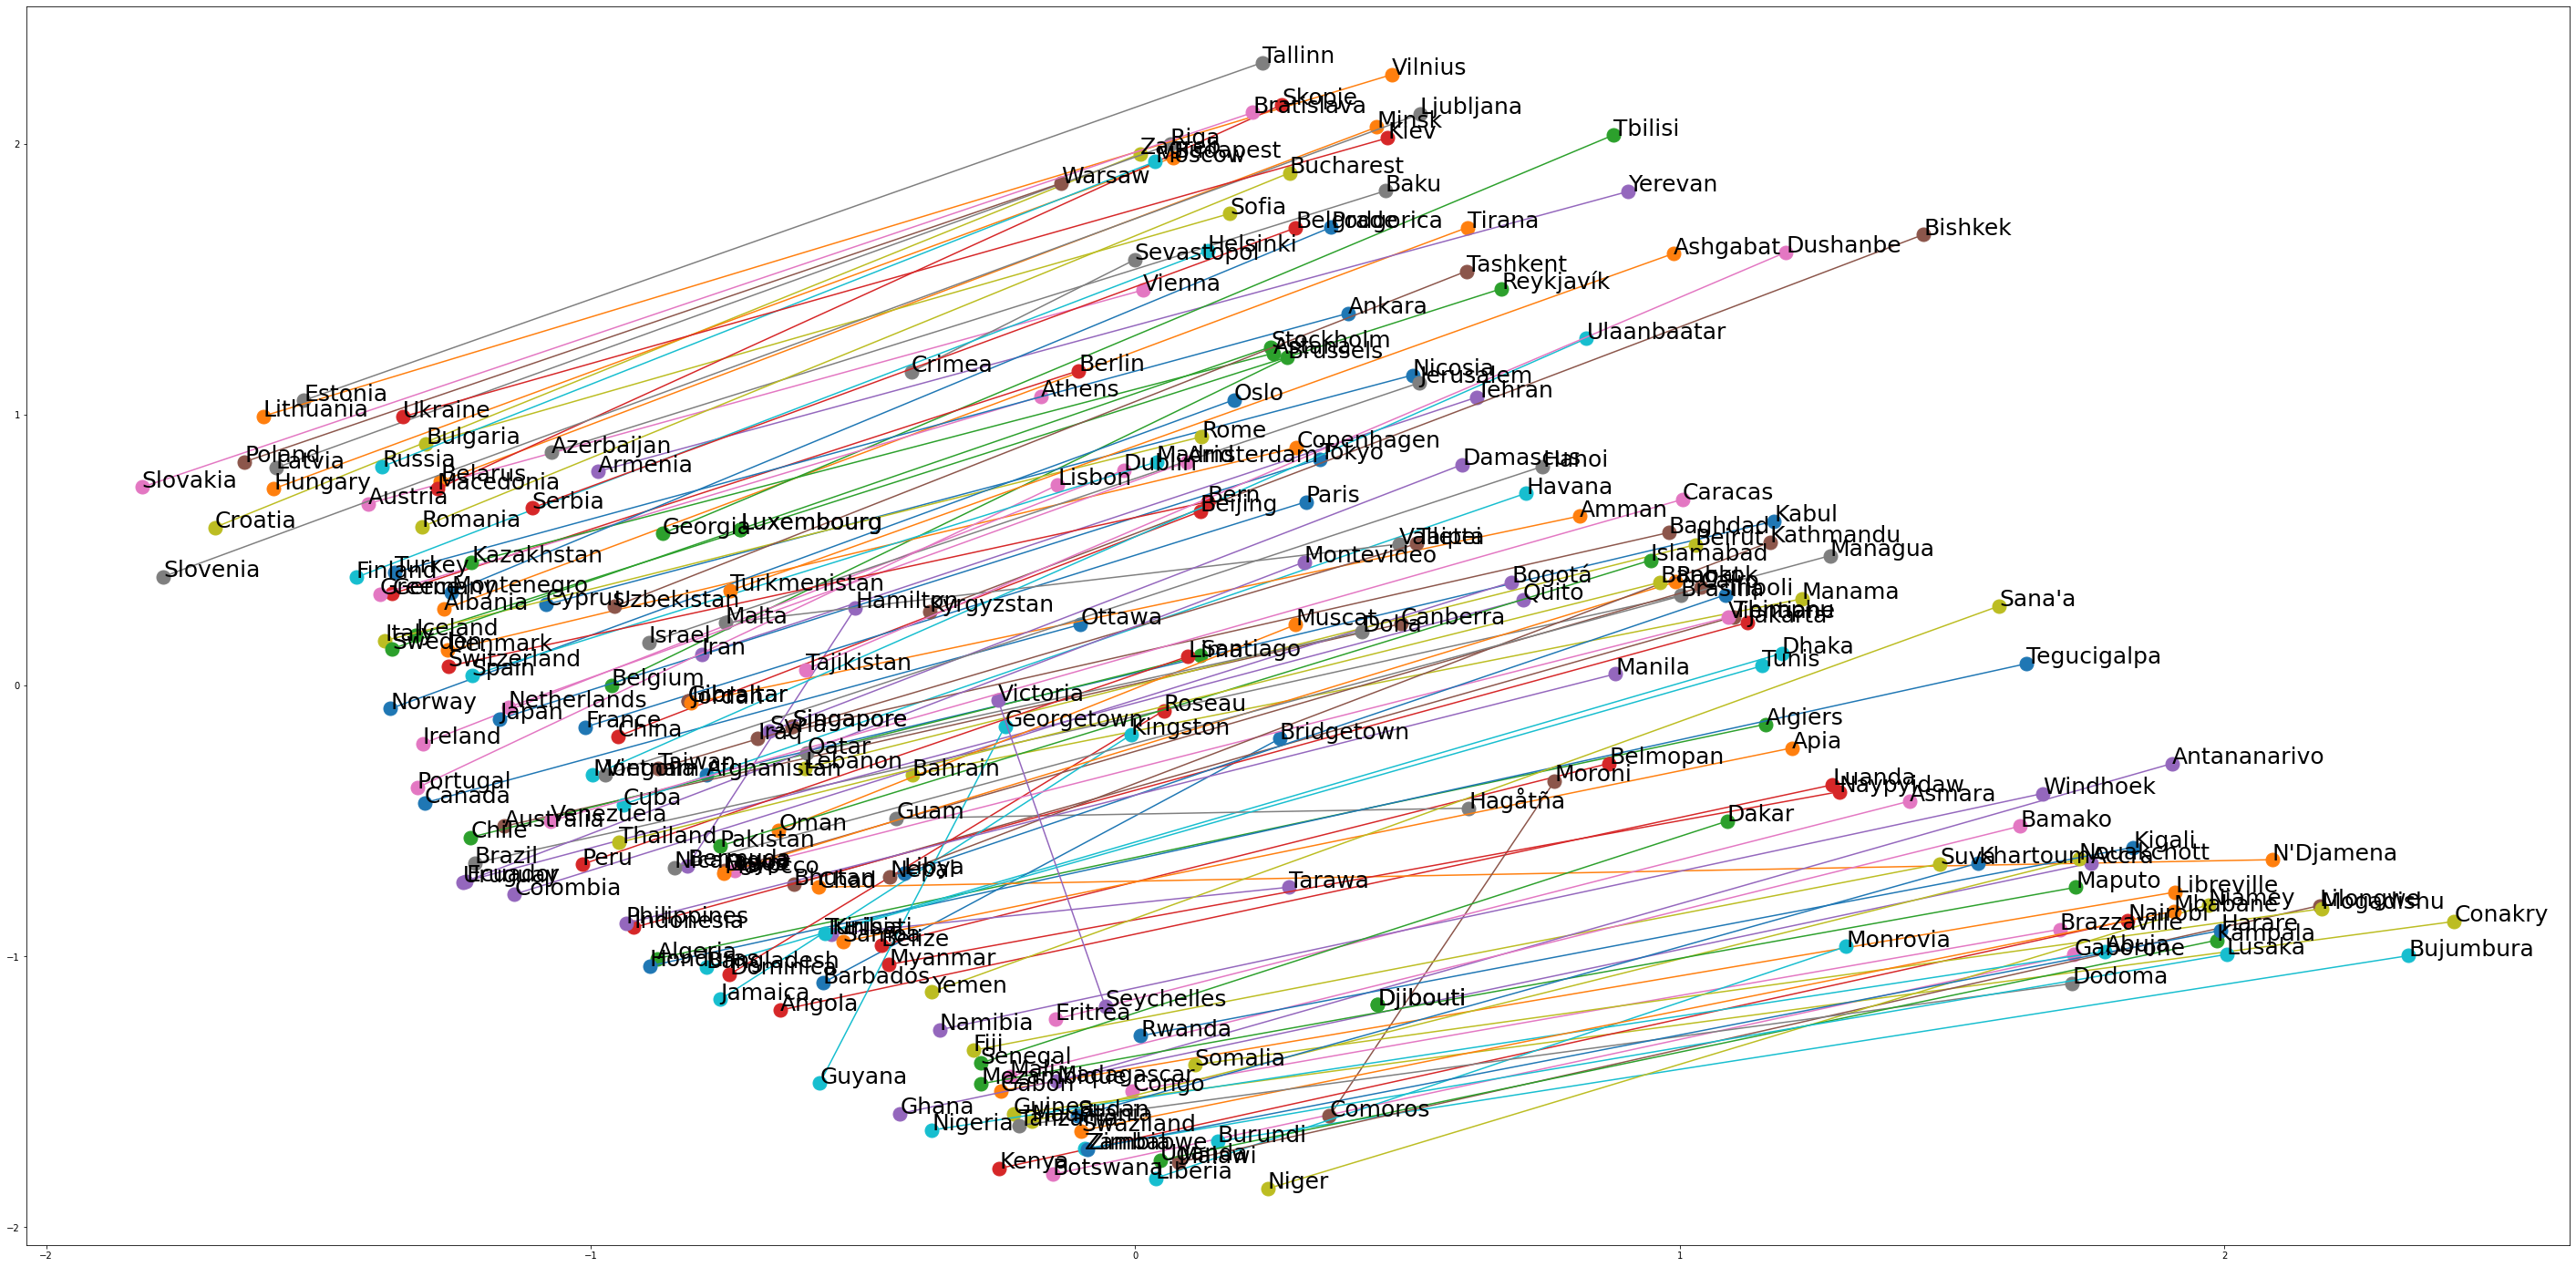

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


#
# TODO
# use PCA from sklearn.decomposition to project the countries and capitals into 2D.
# draw lines connecting each country with its capital
#
# Hint:
# - the function "annotate" can be used to put text onto the plot
#
pca = PCA(n_components = 2,svd_solver = 'full',whiten = True)
pca.fit(geo_vecs)
new_geo = pca.transform(geo_vecs)
plt.figure(figsize= (50,25))
for i in range(0,len(new_geo),2):
    points = new_geo[i:i+2]
    plt.plot(points[:,0],points[:,1],marker ='o',markersize = 15)
    plt.annotate(geo[i],xy =(new_geo[i][0],new_geo[i][1]),fontsize = 25)
    plt.annotate(geo[i+1],xy =(new_geo[i+1][0],new_geo[i+1][1]),fontsize = 25)
plt.show()

## Subtask 4: PCA vs t-SNE on frequent words

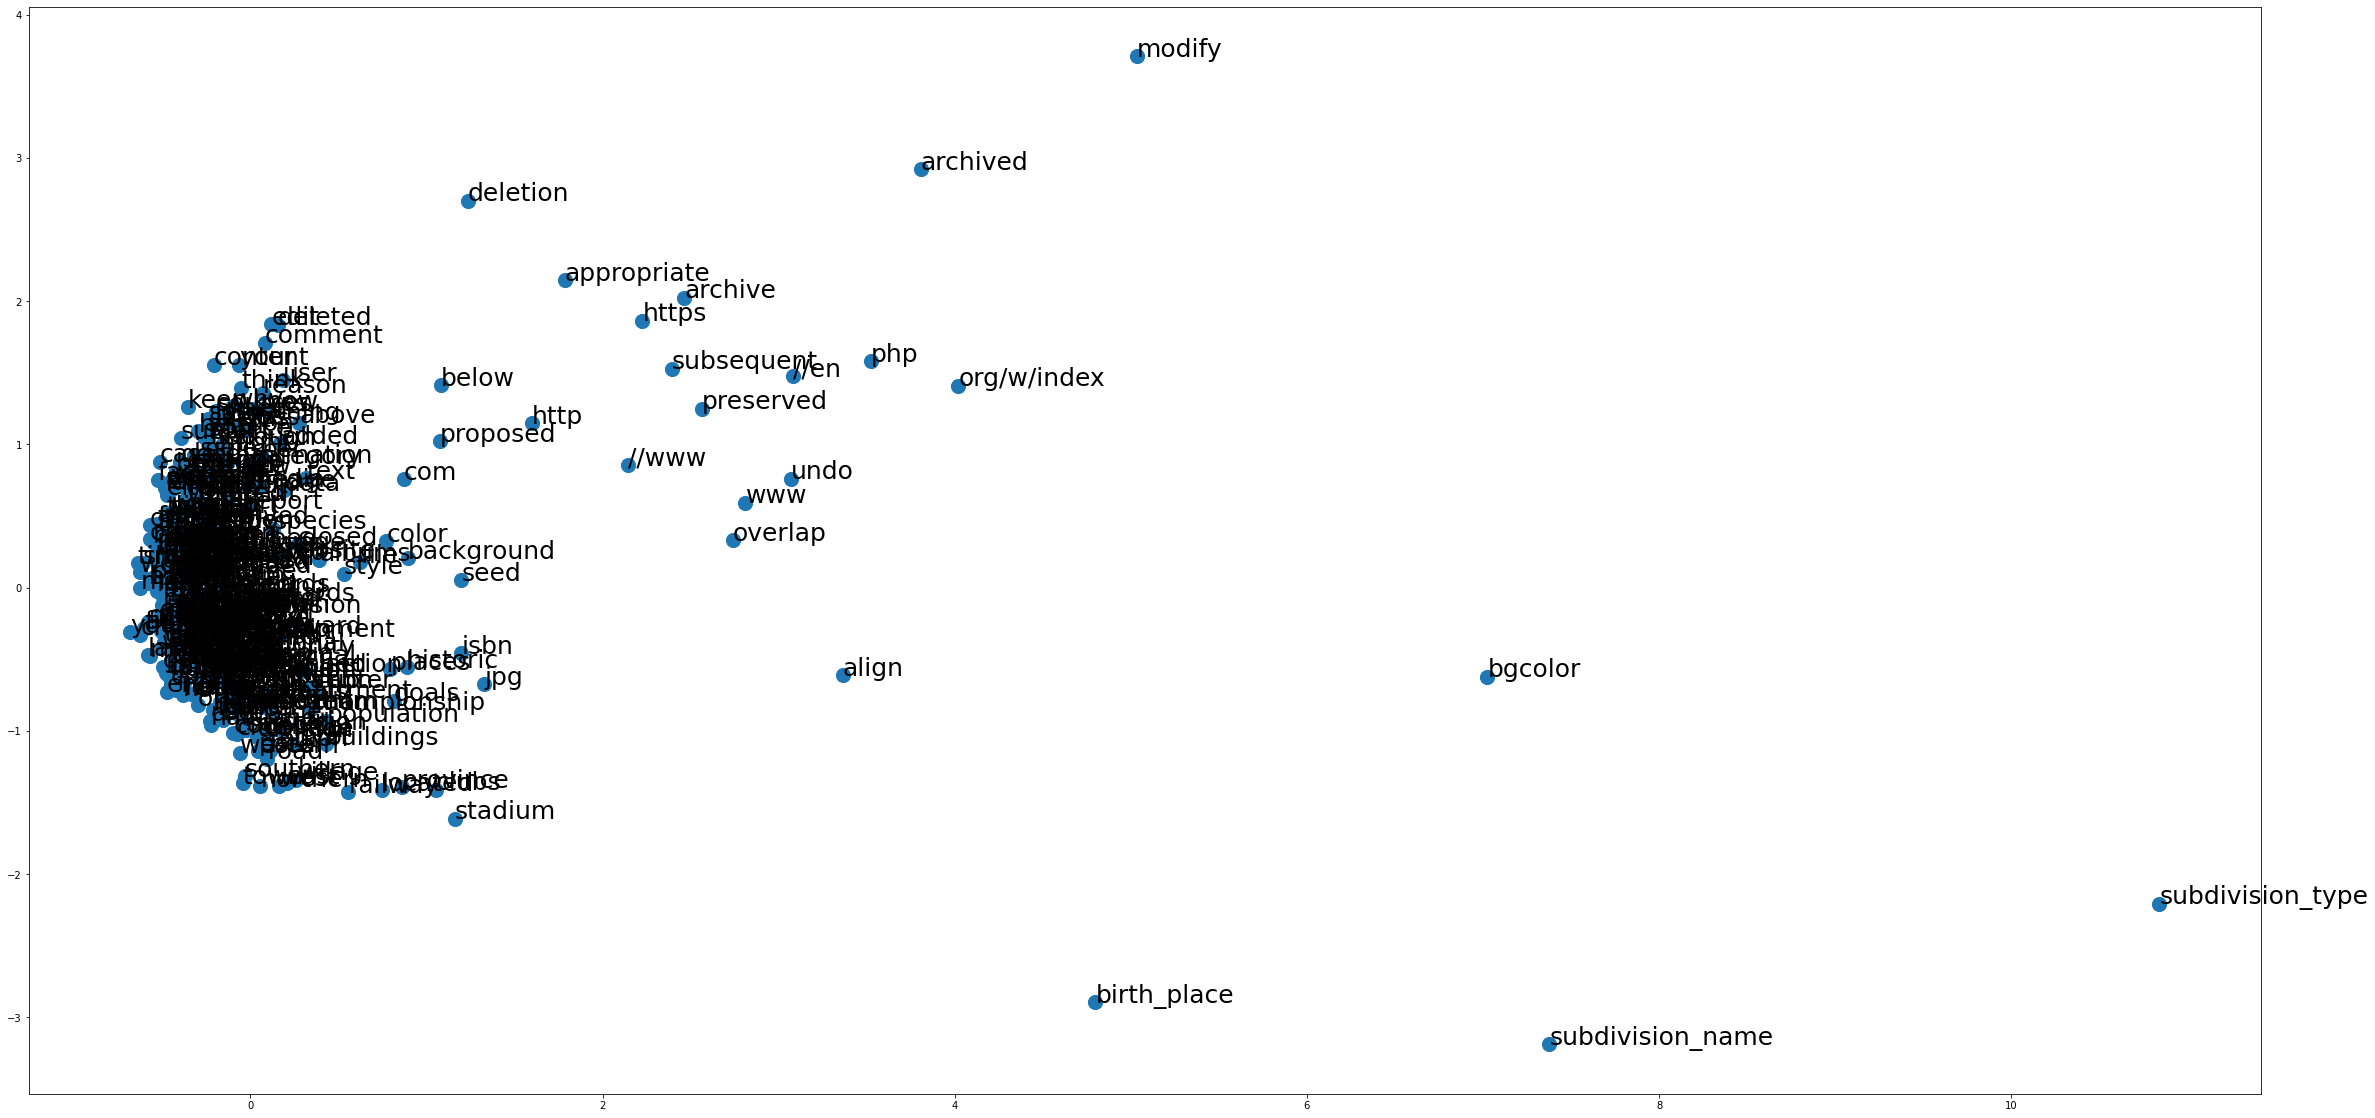

In [19]:
# Select words starting from the 200th to ommit stop words,
# which have at least 3 chars
top_words = [w for (i,w) in enumerate(ftext.idx2word) \
             if i > 200 and len(w) >= 3][:400]
top_inds = [ftext.word2idx[w] for w in top_words]


#
# TODO: make a 2D PCA projection of the selected words.
#
words_vecs = ftext.vec[top_inds]
pca = PCA(n_components= 2)
pca.fit(words_vecs)
new_vecs = pca.transform(words_vecs)
fig = plt.figure(figsize=(40,20))
plt.scatter(new_vecs[:,0],new_vecs[:,1],s = 200)
for i in range(len(new_vecs)):
    plt.annotate(top_words[i],new_vecs[i],fontsize = 25)
plt.show()

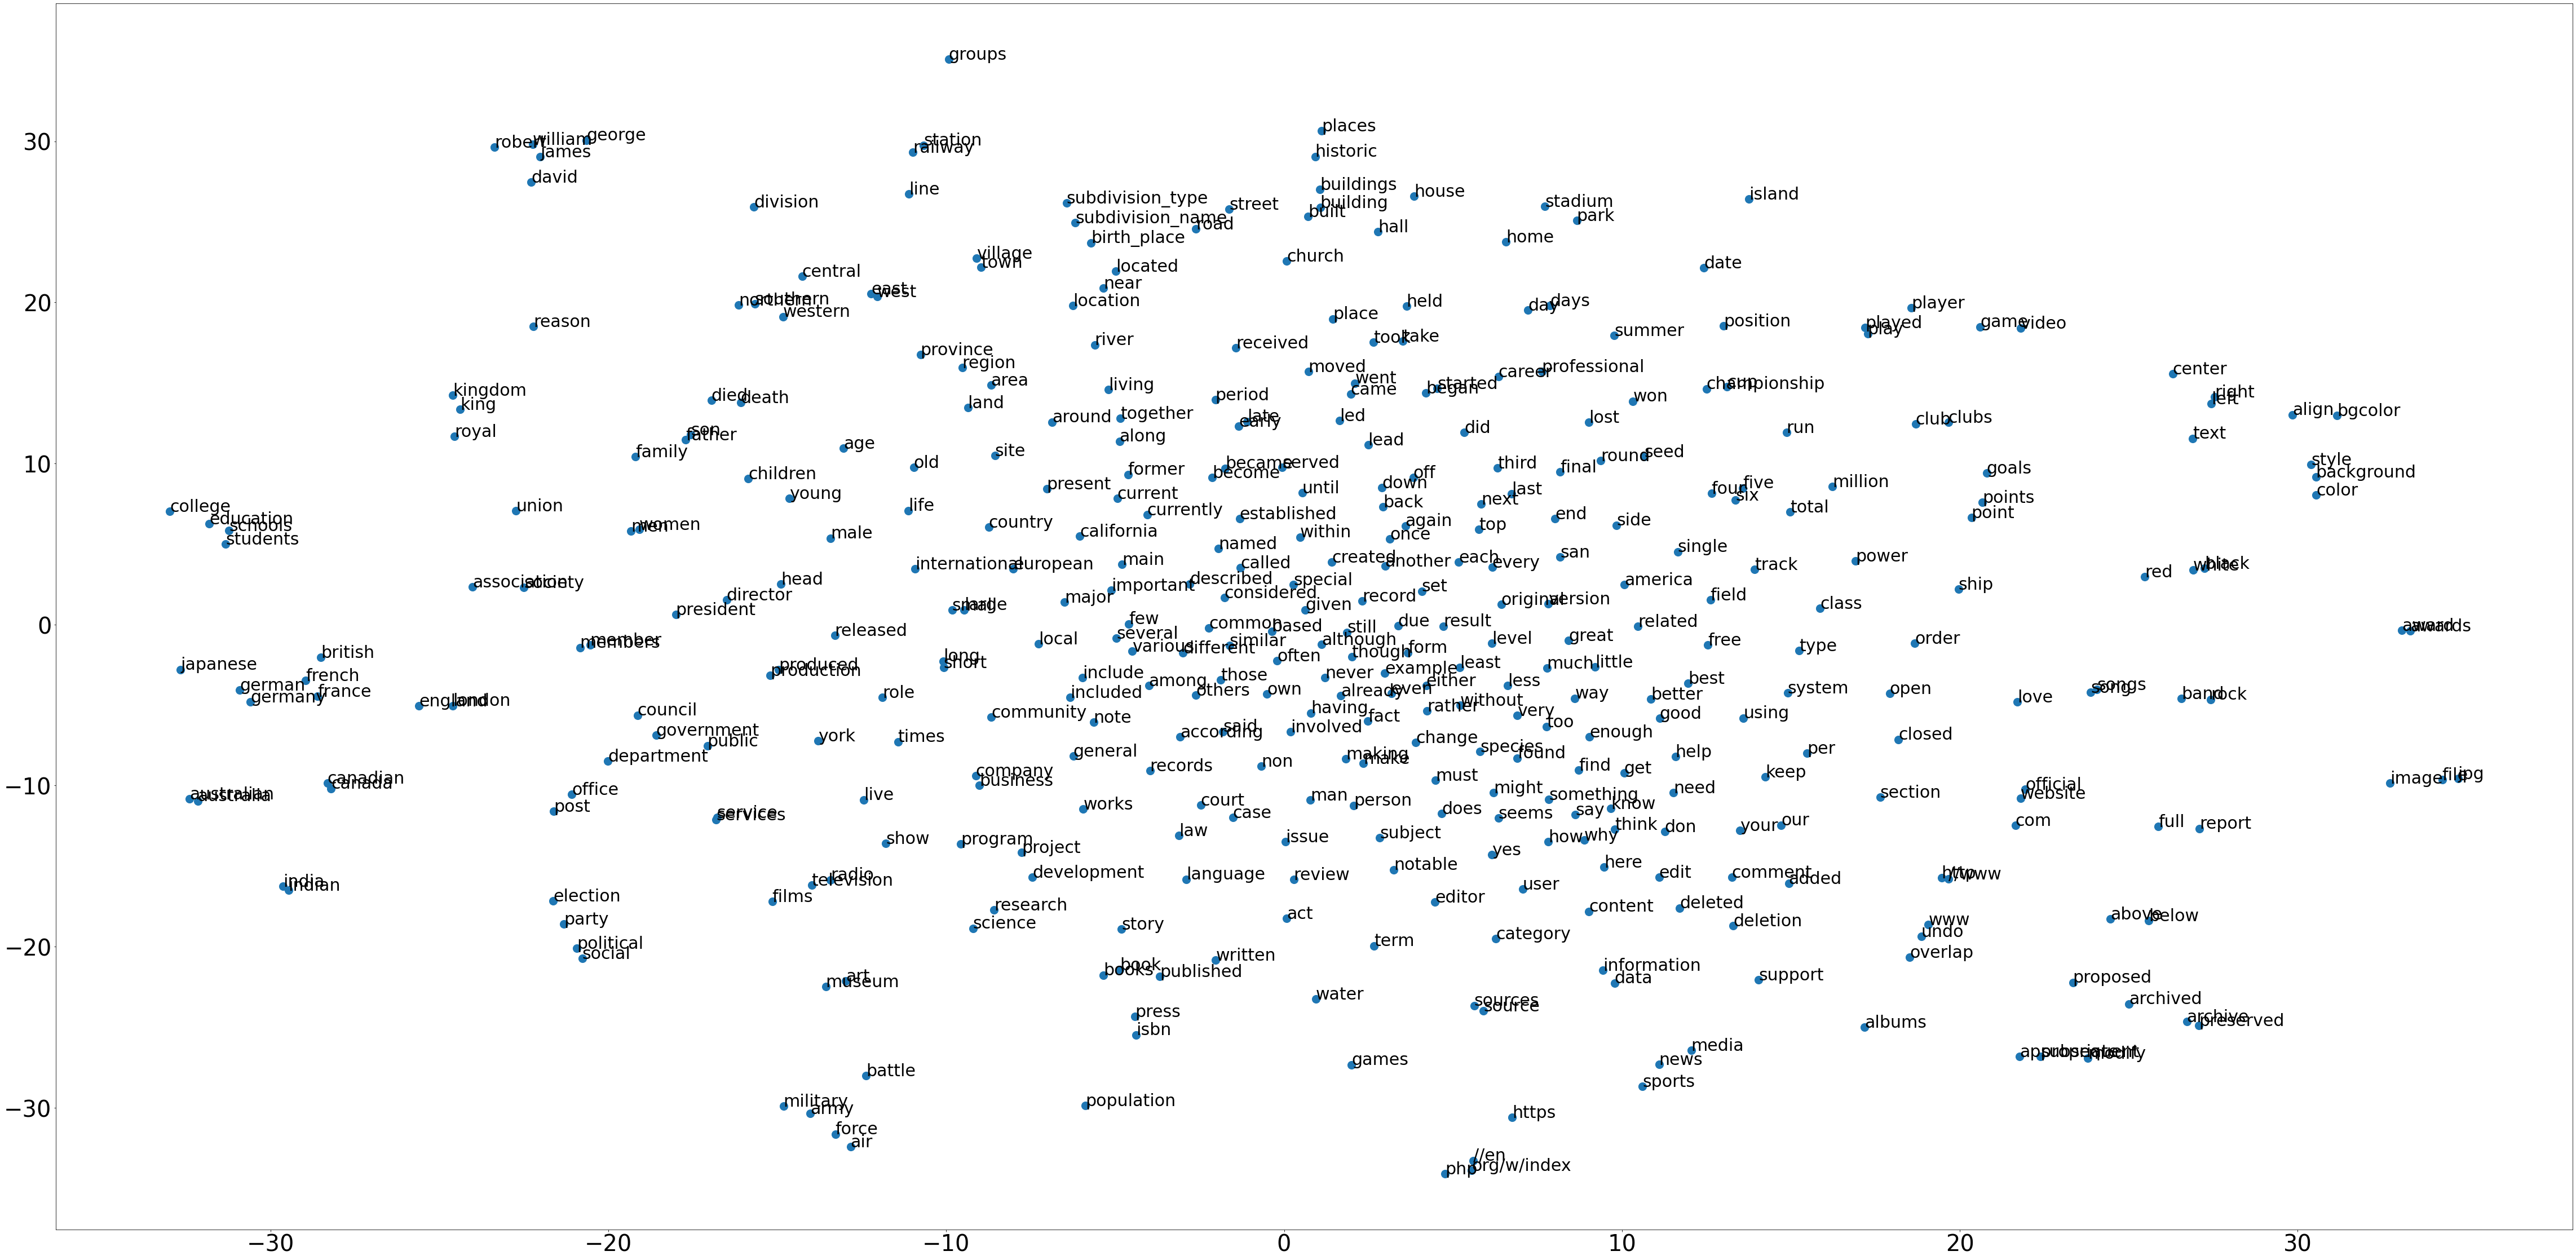

In [20]:
from sklearn.manifold import TSNE

#
# TODO: make a 2D t-SNE projection of the selected words.
# Things will cluster much nicer
#
tsne = TSNE(n_components = 2,random_state= 1)
new_vecs_tsne = tsne.fit_transform(words_vecs)
fig = plt.figure(figsize=(80,40))
plt.xticks(fontsize = 40)
plt.yticks(fontsize = 40)
plt.scatter(new_vecs_tsne[:,0],new_vecs_tsne[:,1],s = 200)
for i in range(len(new_vecs)):
    plt.annotate(top_words[i],new_vecs_tsne[i],fontsize = 30)
plt.show()

In [0]:
# TODO: zomm in on 3 meaningful clusters

Well i dont know how to zoom (i tried some methods from pyplot but resulting plots were too small I would love to know how to do it) but cordinates of clusters are:
- x in [-16,-10] and y in [-34,-30] and cluster is {military,army,force,air}
- x in [-23,-20] and y in [-22,-17] and cluster is {election,party,politicial,social}
- x in [-35,-27] and y in [-5,0] and cluster is {japanese,german,germany,french,france,british}


# Problem 2: kNN Talker [6p + 7bp]

In this exercise you will build a simple chatbot that uses distributed representations of words and sentences to perform a neares neighbor selection of responses.

We have collected two sets of data:
- `./reddit_pairs.txt` of excerpts of [Reddit](https://www.reddit.com/) conversations,
- `./hackernews_pairs.txt` of excertps from [Hackernews](https://news.ycombinator.com/).

The two corpuses are formatted as `tab`-separated pairs of utterances: a `prompt` and a `response`. Successive lines belong to different conversations.

The main idea of the chatbot is to build a representation of the user `input` and of all `prompts` from the corpus. Then select the best (or randomly one of the top few) matches and print the associated `response`.

The key to get the bot working is to create good sentence representations. We will try:
- averaging word embeddings
- using sentence models such as BERT.

### Warning:
The Reddit corpus may contain abusive language, it was not heavily cleaned.

### Tasks
The code below is a starting point, but you can develop you own. The following list suggests some actions to try, along with the points that reflect our subjective hardness. The exercise is worth 6 regular points (i.e. the report, word embedding-based model and BERT-based model), anything on top of it will be counted as a bonus.

1. [MANDATORY] type in a Markdown cell a report of your actions, what did you try, why, what was the result. Show exemplary conversations (they must be probable under your model) [2p].
2. Represent sentences by averaging their word vectors. Properly handle tokenization (you can use regular expressions or e.g. `nltk` library). Describe how you handle lower and upper cased words. Try a fw nearest neighbor selection methods (such as euclidean or cosine distance). See how embedding normalization affects the results (you can normalize individual word vectors, full sentence vectors etc.) [2p]
3. Use the [transformers](https://huggingface.co/transformers) package to load a pretrained BERT model. Use it to represent sentences by e.g. averaging the activations in the last layer [2p].
4. Cherry-pick 3 nice dialogues [1p].
5. Incoportate context: keep a running average of past conversation turns [1p].
6. Do data cleaning, finding rules for good responses [1p].
7. Do profanity cleaning [1p].
8. Try mixing different sentence representation techniques [1p].
9. Try to custer responses to the highest scored prompts. Whic arsponses are more funny: form the largerst or from the smalles cluster? [2p].
10. Implement your own enhancements [?bp].


In [22]:
prompts = []
responses = []
err_lines = []
with open('./reddit_pairs.txt') as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        line = line.split('\t')
        if len(line)!=2:
            err_lines.append(line)
        else:
            prompts.append(line[0])
            responses.append(line[1])
print(f"Failed to parse the following {len(err_lines)} lines: {err_lines}") 
print(f"Sample fialogue pairs: \n{pprint.pformat(list(zip(prompts[:15], responses)))}")

Failed to parse the following 7 lines: [['1602 link karma', '11259 comment karma', 'damn you got almost all your karma here'], ['lol'], ['50$ skin pls'], ['omg his posting how'], ['11', 'inches to be precise :)', 'holy shit your girl has found herself a fuckin unicorn!'], ['( ) no fuk'], ['looks like you post on multiple porn subreddits']]
Sample fialogue pairs: 
[('show', 'me your moves?'),
 ('haters gonna hate', 'hate'),
 ('i think he is doing sarcasm.',
  'hahaha, you stupid twat, go and have a wank'),
 ('i can do 38 for void head :)', '39k man cant go for 38k'),
 ('brb getting hit by a car', 'did your mate, also buy you a computer?'),
 ('reason ?', 'to pay for bandwidth to troll people online.'),
 ('*155k notes...*', 'welcome to tumblr'),
 ('is it just me or is this pitched up?',
  'might be to avoid copyright issues.'),
 ('no chapter this week bud :(', '**cough*'),
 ("that's gonna come back for a block in the back",
  "but it doesn't matter. fuck this game. connor cook playing ful

In [0]:
class BasicEncoder:
    def encode(self, sentence):
        # this is a base class!
        raise NotImplementedError

    def encode_corpus(self, sentences):
        ret = [self.encode(sentence) for sentence in tqdm(sentences)]
        return np.vstack(ret)

The code below implements a simple baseline: we encode each sentence as a sparse vector which sums word occurrences.

In [24]:
class OneHotEncoder(BasicEncoder):
    def __init__(self, sentences):
        self.vectorizer = sklearn.feature_extraction.text.CountVectorizer()
        self.vectorizer.fit(sentences)
    
    def encode(self, sentence):
        return self.vectorizer.transform([sentence])[0]

    def encode_corpus(self, sentences):
        # Override because sklearn already works on batches
        encodings = self.vectorizer.transform(sentences)
        # Note: this code needs to handl the scipy sparse matrix
        # which has subtle differences with numpy ndarrays
        norms = np.array((encodings.power(2)).sum(1))**0.5
        encodings = encodings.multiply(1.0 / norms)
        return encodings

encoder = OneHotEncoder(prompts)
encodings = encoder.encode_corpus(prompts)

prompt = "Ultimate question: Windows or Linux?"
enc = encoder.encode(prompt)

# Deal with encodings being sparse matrices. Word2vecs will not have the pecularities
scores = (encodings @ enc.T).toarray().ravel()
top_idx = scores.argsort()[-10:][::-1]

for idx in top_idx:
    print(scores[idx], prompts[idx], ':', responses[idx])

1.0606601717798212 is in windows or in linux? : windows
1.0 p or i : yes
1.0 1 or 2? : * or 3
1.0 ......or 2 : had the same thought!
1.0 $ or ? :) : is usually usd
1.0 1 or 2? : 2 in the car this morning for me
1.0 1 or 3 : thx
1.0 question? : *small*
1.0 1 or 2? : 2, and lots of it.
1.0 windows : wtf where is the program how do i type it in, not enough info i am getting


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [0]:
# TODO: build a simple dialogue system using these k-neares neighbor matches, 
# perform a few test conversations

In [26]:
err_cnt = []
cnt = 0

class Word2VecEncoder(BasicEncoder):
    def __init__(self, vecs):
        self._vecs = vecs
        
    def _get_vec(self, word):
        # Find the vector for word, or use a suitbale out-of-vocabulary vector
        # For extra points try backing off to a lowercased dictionary
        if word not in self._vecs.word2idx.keys():
            global err_cnt
            err_cnt.append(word)
            return 0
        return self._vecs.vec[self._vecs.word2idx[word]]

    def encode(self, sentence):
        ret = np.zeros(self._vecs.vec.shape[1])
        tokenizer = RegexpTokenizer(r'\w+')
        global cnt
        for token in tokenizer.tokenize(sentence):
            cnt += 1
            word_vec = self._get_vec(token)
            ret += word_vec
        ret /= (np.linalg.norm(ret) + 1e-5)
        return ret

    def find_nearest_cosine(self,sentence,prompts_vecs,responses):
        encoded_sentence = self.encode(sentence)
        idx = np.argmax(encoded_sentence.dot(prompts_vecs.T))
        return responses[idx]
    def find_nearest_euclidian(self,sentence,prompts_vecs,respons):
        encoded_sentence = self.encode(sentence)
        dists = np.sqrt(((prompts_vecs - encoded_sentence)**2).sum(axis=1))
        return responses[np.argmin(dists)]

encoder = Word2VecEncoder(word2vec)
encodings = encoder.encode_corpus(prompts)

In [27]:
print(len(list(set(err_cnt))))
print(len(err_cnt))
print(cnt)
print(len(err_cnt)/cnt)

5437
46612
409244
0.11389782134863309


In [28]:
set(err_cnt)

{'hentai',
 '1111',
 '2deep4me',
 '30',
 'mrw',
 '67',
 '17th',
 '27k',
 'itgreen',
 'yupgreat',
 '92k',
 'meadded',
 '55gal',
 'sid',
 'clit',
 '651',
 'xxxxx',
 'where2',
 'ashley5',
 'betty',
 '1002',
 'peeve',
 '495',
 'orton',
 'completely17',
 'blue190',
 'artemis',
 'snoo',
 '18th',
 'didntits',
 '2cinematic4me',
 'memeedit',
 '953',
 '170',
 'atletico',
 'celebi',
 'boi',
 'cruz',
 'mewtwo',
 '1495decided',
 'sacramento',
 '4key',
 '2xp',
 'top8',
 '2gig',
 '325',
 'noobmuch',
 'fanfic',
 '113k',
 'miley',
 'cleveroriginal',
 'bill917',
 '406',
 '57k',
 '88k',
 'lp2',
 '7000',
 'am_map',
 'thothats',
 'boxyour',
 'shithole',
 'christi',
 'oedit',
 '30d',
 '603',
 '2595',
 '3840x2160',
 'm__m',
 '5funny',
 'brb',
 'lvl',
 '1up1upper',
 '201k',
 'cringeworthy',
 '20s',
 'mexicans',
 'main1',
 'dealadd',
 'spongebob',
 'feb',
 '1basically',
 'g1',
 'instagram',
 'browner',
 'eric',
 'derek',
 'no5',
 '1h29min',
 'chem',
 '724',
 '65dos',
 '128gb',
 'attractivestep',
 'keysedit',
 

In [29]:
print(encoder.find_nearest_cosine("how are you doing",encodings,responses))
print(encoder.find_nearest_cosine("what user name",encodings,responses))
print(encoder.find_nearest_cosine("what is flair",encodings,responses))
encoder.find_nearest_cosine("i like video",encodings,responses)

google that user name
with the rondo flair...
video


'maybe cuz youre on mobile? idk why else you wouldnt be able to.'

In [30]:
print(encoder.find_nearest_cosine("i like bananas",encodings,responses))
print(encoder.find_nearest_cosine("why so mean",encodings,responses))
print(encoder.find_nearest_cosine("sexy beasts",encodings,responses))
encoder.find_nearest_cosine("i love you",encodings,responses)

the fuck did you say?
they are such sexy beasts
thx


'i love you too'

In [31]:
print(encoder.find_nearest_cosine("star wars is the best movie",encodings,responses))
print(encoder.find_nearest_cosine("best movie",encodings,responses))
print(encoder.find_nearest_cosine("discrepancy",encodings,responses))
encoder.find_nearest_cosine("mean",encodings,responses)

not quite.
discrepancy?
dry your eyes


'haha ok thought you had gone a bit crazy ;)'

In [32]:
print(encoder.find_nearest_euclidian("star wars is the best movie",encodings,responses))
print(encoder.find_nearest_euclidian("best movie",encodings,responses))
print(encoder.find_nearest_euclidian("discrepancy",encodings,responses))
encoder.find_nearest_euclidian("mean",encodings,responses)

not quite.
discrepancy?
dry your eyes


'haha ok thought you had gone a bit crazy ;)'

In [33]:
print(encoder.find_nearest_euclidian("i like bananas",encodings,responses))
print(encoder.find_nearest_euclidian("why so mean",encodings,responses))
print(encoder.find_nearest_euclidian("what is flair",encodings,responses))
encoder.find_nearest_euclidian("i like video",encodings,responses)

the fuck did you say?
they are such sexy beasts
video


'maybe cuz youre on mobile? idk why else you wouldnt be able to.'

In [0]:
from transformers import BertTokenizer, BertModel

In [0]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
model.eval()
model.to('cuda')
input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute and really handsome", add_special_tokens=True),device = 'cuda').unsqueeze(0)  # Batch size 1
outputs = model(input_ids)

last_hidden_states = outputs[0]

In [45]:
last_hidden_states.shape

torch.Size([1, 11, 768])

In [46]:
torch.mean(last_hidden_states,axis=1).shape

torch.Size([1, 768])

In [47]:
len(prompts)

72807

In [0]:
from IPython.display import clear_output
def bert_prompts_emembeddings(tokenizer,model,prompts):
    with torch.no_grad():
        new_prompts = torch.zeros((len(prompts),768),device = 'cuda')
        for i in range(len(prompts)):
            if i%50 == 0:
                clear_output()
                print(i/len(prompts))
            input_ids = torch.tensor(tokenizer.encode(prompts[i], add_special_tokens=True),device = 'cuda').unsqueeze(0)  # Batch size 1
            outputs = model(input_ids)
            new_prompts[i] = torch.mean(outputs[0],axis=1)
        return new_prompts

In [0]:
def bert_find_nearest(bert_prompts,tokenizer,model,question,responses):
    input_ids = torch.tensor(tokenizer.encode(question, add_special_tokens=True),device = 'cuda').unsqueeze(0)
    with torch.no_grad():
        outputs = model(input_ids)[0]
    outputs = torch.mean(outputs,axis=1)
    idx = torch.argmax(outputs.matmul(bert_prompts.T))
    return responses[idx]

Line below works for some time.

In [52]:
bert_prompts = bert_prompts_emembeddings(tokenizer,model,prompts)

0.9999038553985193


In [72]:
bert_prompts.shape

torch.Size([72807, 768])

In [106]:
print(bert_find_nearest(bert_prompts,tokenizer,model,"i like bananas",responses)) #correct
print(bert_find_nearest(bert_prompts,tokenizer,model,"what about star wars",responses)) #wrong
print(bert_find_nearest(bert_prompts,tokenizer,model,"i like star wars",responses)) #correct
print(bert_find_nearest(bert_prompts,tokenizer,model,"whats your buddy name",responses)) #Well this is correct
print(bert_find_nearest(bert_prompts,tokenizer,model,"i have shiny charmander",responses))#pokemon name
print(bert_find_nearest(bert_prompts,tokenizer,model,"i have shiny pikachu",responses))#pokemon name
print(bert_find_nearest(bert_prompts,tokenizer,model,"i have shiny squirtle",responses))#pokemon name nice change
print(bert_find_nearest(bert_prompts,tokenizer,model,"dark souls are hard",responses)) #correct
print(bert_find_nearest(bert_prompts,tokenizer,model,"i keep dying in dark souls",responses))
print(bert_find_nearest(bert_prompts,tokenizer,model,"i keep dying in dark souls 3",responses))
print(bert_find_nearest(bert_prompts,tokenizer,model,"i keep dying in bloodborne",responses)) #seems bloodborne and dark souls are similar
print(bert_find_nearest(bert_prompts,tokenizer,model,"Hard games",responses))
print(bert_find_nearest(bert_prompts,tokenizer,model,"recommend me horrors",responses))
print(bert_find_nearest(bert_prompts,tokenizer,model,"recommend me movies",responses))
print(bert_find_nearest(bert_prompts,tokenizer,model,"kardashian news",responses))
print(print(bert_find_nearest(bert_prompts,tokenizer,model,"would you like coffe?",responses)))

me too
that's the thing on the ice with the puck
my buddy says the same thing
hatched shiny!
and whats your request?
and whats your request?
man who have big ball walk with bow leg
oh, that makes sense now
knew it
m8 u wot?!
knew it
hard
okay, sent
sent
reddit dot co dot uk
i'm online now
None


So I decided to use reddit text due to fact that number of unknown words in it for words2vec model is much smaller than in hackernews. It is 11%, and more than half of them are some numbers. \\
Using cosine or euclidian does not seem to be changing anything. \\
Well answers are not that bad sometimes, I mean answer to 'i love you' is good and answer to 'star wars is best movie' seems okay. Also answer to 'i like video' seems to be around good answer looking at first part of it, liking video has nothing in common with being on mobile but it is correct answer looking just at meaning. Second part of answer is much worse but still floats around correct answer. \\
Now bert part, it is doing much better than previous model. Most of anwsers are more or less correct. Exception is answer to 'i like star wars'. My favourite one is 'whats your buddy name' and answer 'hatched shiny', buddy is pokemon in pokemon go which walks around world with you and shiny are really rare ones.